## Notebook Purpose
This notebook is used to compute and plot seasonal SMB for Black Changri Nup Glacier (Figure 9)  

#### Last updated: March 7, 2023

## TODO:
- Update imports when new library has been built up with all updates
-Generalise path to data products during revisions, after the data distribution plan is finalized


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'


In [2]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from imview import pltlib
import pandas as pd
from pygeotools.lib import warplib,geolib,iolib,malib,filtlib,timelib
import os,sys,glob,shutil
from velocity_proc import glac_dyn, constants, velocity_filter, velocity_timeseries

/swbuild/sbhusha1/miniconda3/envs/bhushanGDAL3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline

In [4]:
img1_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/orthoimage/20151102_10400100125E8E00_ortho_res_2.0m.tif'
img2_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/orthoimage/20160422_103001005444C600_ortho_res_2.0m.tif'
img3_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/orthoimage/20161025_104001002469AD00_ortho_res_2.0m.tif'
dem_fn = '/nobackup/sbhusha1/chapter2/changrinup/20151102_aligned/20151102_aligned-trans_source-DEM.tif'
smb_winter_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2015-11-02_to_2016-04-22_lag_smb_products/black_changri_nup_2015-11-02_to_2016-04-22_smb_dhdt.tif'
smb_summer_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2016-04-22_to_2016-10-25_lag_smb_products/black_changri_nup_2016-04-22_to_2016-10-25_smb_dhdt.tif'
img_ds_list = warplib.memwarp_multi_fn([img1_fn,img2_fn,img3_fn,dem_fn,smb_winter_fn,smb_summer_fn])
img1,img2,img3,dem,smb_winter,smb_summer = [iolib.ds_getma(ds) for ds in img_ds_list]



Warping all inputs to the following:
Resolution: 2.0
Extent: [476533.0, 3090519.2852778127, 483001.0, 3099253.0]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: /nobackup/sbhusha1/chapter2/changrinup/20230217/orthoimage/20151102_10400100125E8E00_ortho_res_2.0m.tif
nl: 4367 ns: 3234 res: 2.000
0...10...20...30...40...50...60...70...80...90...2 of 6: /nobackup/sbhusha1/chapter2/changrinup/20230217/orthoimage/20160422_103001005444C600_ortho_res_2.0m.tif
nl: 4367 ns: 3234 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...3 of 6: /nobackup/sbhusha1/chapter2/changrinup/20230217/orthoimage/20161025_104001002469AD00_ortho_res_2.0m.tif
nl: 4367 ns: 3234 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...4 of 6: /nobackup/sbhusha1/chapter2/changrinup/20151102_aligned/20151102_aligned-trans_source-DEM.tif
nl: 4367 ns: 3234 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90...5 of 6: /noba

In [5]:
ds_extent = geolib.ds_extent(img_ds_list[0])
fig_extent = [ds_extent[0],ds_extent[2],ds_extent[1],ds_extent[3]]

In [6]:
glac_shp = gpd.read_file('/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp')

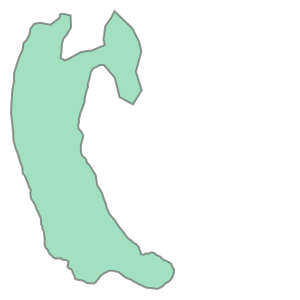

In [7]:
glac_shp.geometry.values[0]

In [8]:
figure_xlim = (477822.34253694705, 480280.62196515594)
figure_ylim = (3094345.7189120646, 3098063.1170717953)

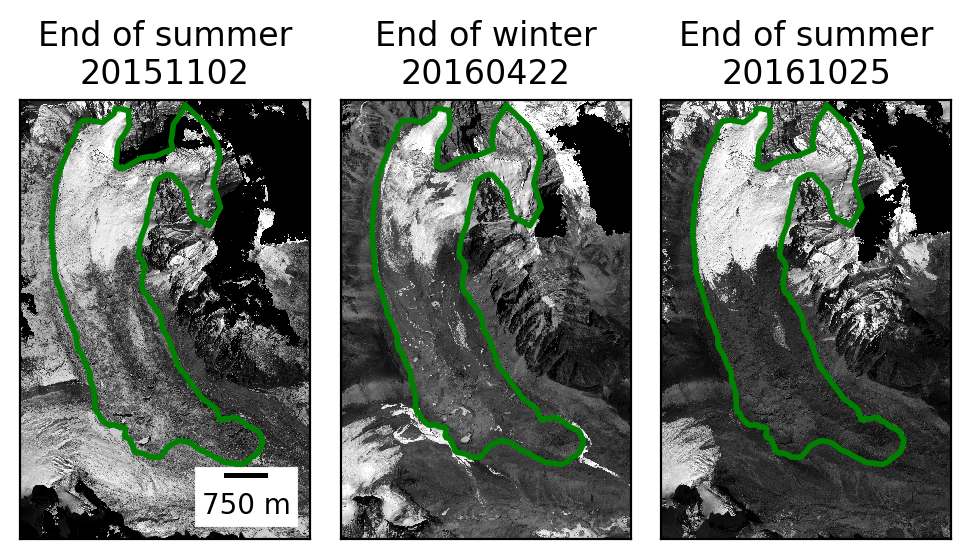

In [9]:
f,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(5,5))
pltlib.iv(img1,ax=ax[0],cmap='gray',cbar=False,scalebar=False,extent=fig_extent,title='End of summer\n20151102')
pltlib.iv(img2,ax=ax[1],cmap='gray',cbar=False,scalebar=False,extent=fig_extent,title='End of winter\n20160422')
pltlib.iv(img3,ax=ax[2],cmap='gray',cbar=False,scalebar=False,extent=fig_extent,title='End of summer\n20161025')
pltlib.add_scalebar(ax[0],res=2)


for axa in ax.ravel():
        glac_shp.plot(ax=axa,edgecolor='green',facecolor='None',linewidth=2)
        axa.set_xlim(figure_xlim)
        axa.set_ylim(figure_ylim)
f.savefig('/nobackup/sbhusha1/chapter2/figures/BlackChangriNup_seasonal_orthoimage.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

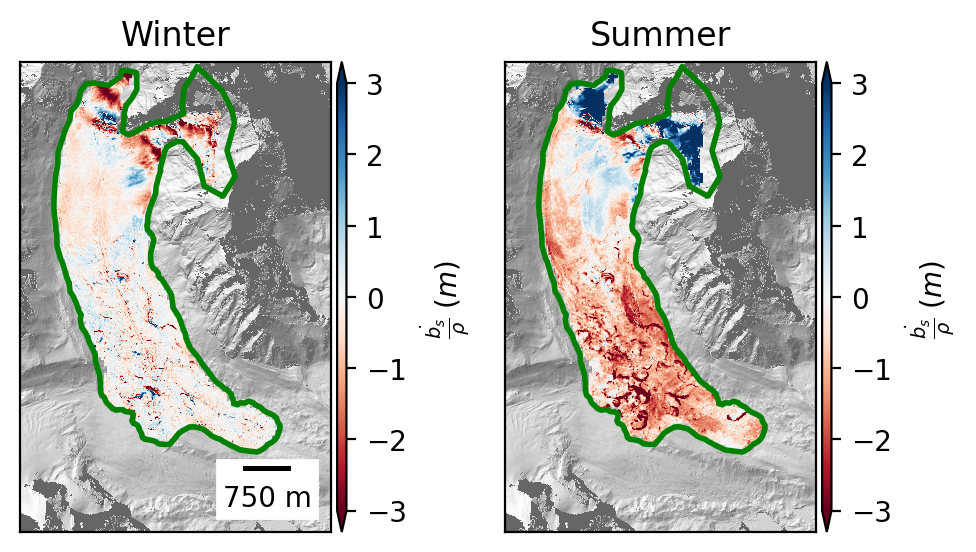

In [10]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(5,5))
pltlib.iv(velocity_timeseries.mask_by_shp(glac_shp.geometry,smb_winter,ds=img_ds_list[5]),
          ax=ax[0],cmap='RdBu',cbar=True,scalebar=False,extent=fig_extent,
          title='Winter',hillshade=True,ds=img_ds_list[3],clim=(-3,3),
          skinny=False,label=r'$\frac{\dot{{b}_{s}}}{\rho}\;(m)$ ',full_bg_stretch=False,overlay_alpha=1)
pltlib.iv(velocity_timeseries.mask_by_shp(glac_shp.geometry,smb_summer,ds=img_ds_list[5]),
          ax=ax[1],cmap='RdBu',cbar=True,scalebar=False,extent=fig_extent,
          title='Summer',hillshade=True,ds=img_ds_list[3],clim=(-3,3),
          skinny=False,label=r'$\frac{\dot{{b}_{s}}}{\rho}\;(m)$ ',full_bg_stretch=False,overlay_alpha=1)
pltlib.add_scalebar(ax[0],res=2)


for axa in ax.ravel():
        glac_shp.plot(ax=axa,edgecolor='green',facecolor='None',linewidth=2)
        axa.set_xlim(figure_xlim)
        axa.set_ylim(figure_ylim)
f.savefig('/nobackup/sbhusha1/chapter2/figures/BlackChangriNup_seasonal_smb.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

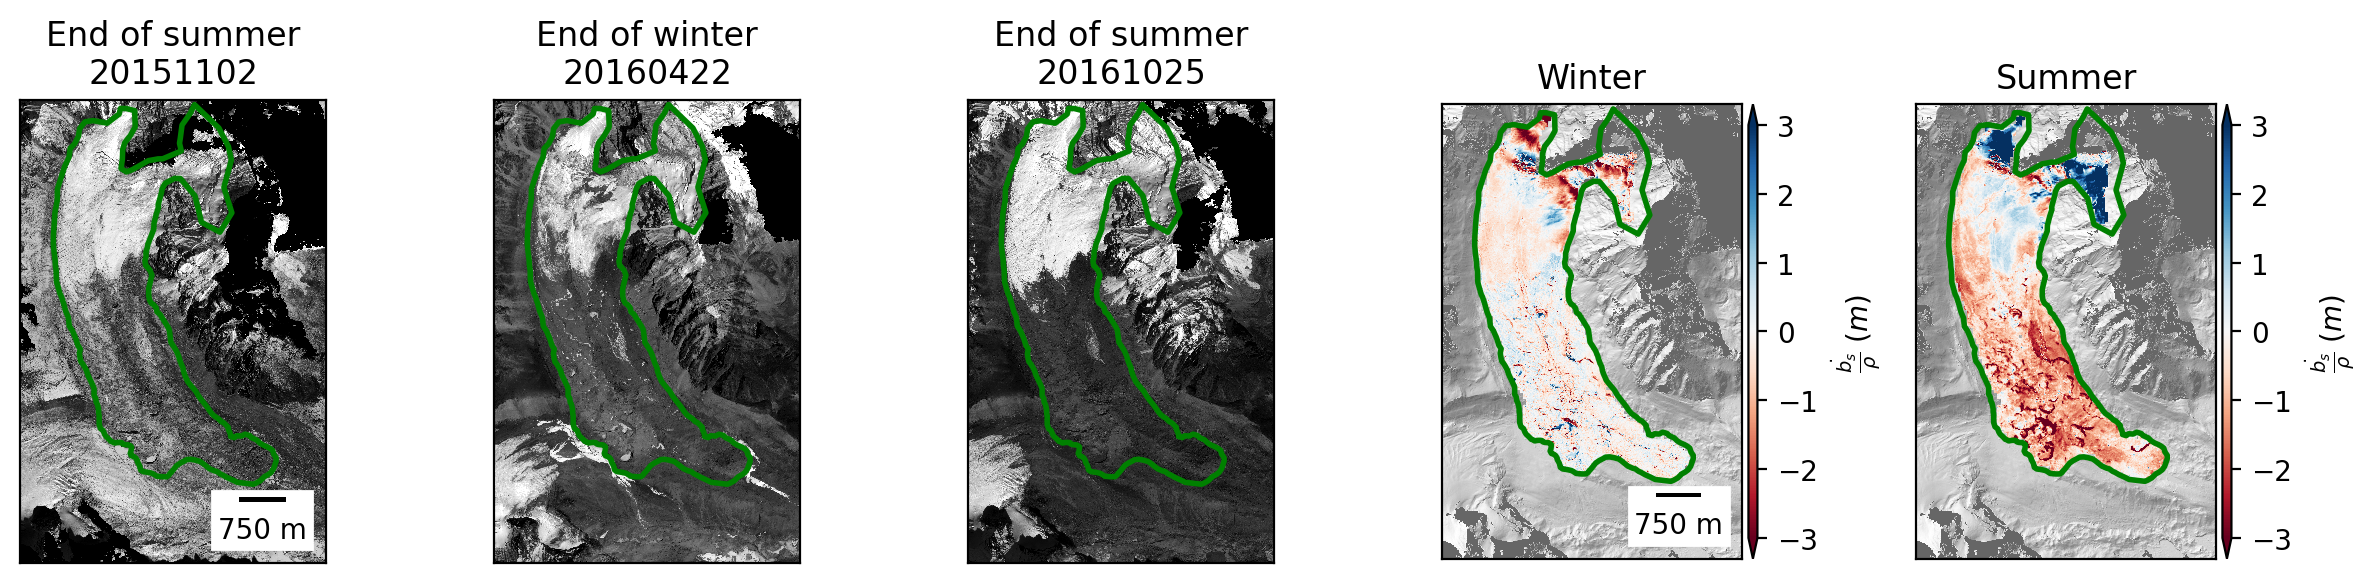

In [11]:
f,ax = plt.subplots(1,5,sharex=True,sharey=True,figsize=(12,7))
pltlib.iv(img1,ax=ax[0],cmap='gray',cbar=False,scalebar=False,extent=fig_extent,title='End of summer\n20151102')
pltlib.iv(img2,ax=ax[1],cmap='gray',cbar=False,scalebar=False,extent=fig_extent,title='End of winter\n20160422')
pltlib.iv(img3,ax=ax[2],cmap='gray',cbar=False,scalebar=False,extent=fig_extent,title='End of summer\n20161025')
pltlib.add_scalebar(ax[0],res=2)

pltlib.iv(velocity_timeseries.mask_by_shp(glac_shp.geometry,smb_winter,ds=img_ds_list[5]),
          ax=ax[3],cmap='RdBu',cbar=True,scalebar=False,extent=fig_extent,
          title='Winter',hillshade=True,ds=img_ds_list[3],clim=(-3,3),
          skinny=False,label=r'$\frac{\dot{{b}_{s}}}{\rho}\;(m)$ ',full_bg_stretch=False,overlay_alpha=1)
pltlib.iv(velocity_timeseries.mask_by_shp(glac_shp.geometry,smb_summer,ds=img_ds_list[5]),
          ax=ax[4],cmap='RdBu',cbar=True,scalebar=False,extent=fig_extent,
          title='Summer',hillshade=True,ds=img_ds_list[3],clim=(-3,3),
          skinny=False,label=r'$\frac{\dot{{b}_{s}}}{\rho}\;(m)$ ',full_bg_stretch=False,overlay_alpha=1)
pltlib.add_scalebar(ax[3],res=2)

for axa in ax.ravel():
        glac_shp.plot(ax=axa,edgecolor='green',facecolor='None',linewidth=2)
        axa.set_xlim(figure_xlim)
        axa.set_ylim(figure_ylim)
plt.tight_layout()
#f.savefig('/nobackup/sbhusha1/chapter2/figures/BlackChangriNup_seasonal_orthoimage.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

In [12]:
smb_winter_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2015-11-02_to_2016-04-22_lag_smb_products/black_changri_nup_2015-11-02_to_2016-04-22_smb_dhdt.tif'
smb_summer_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2016-04-22_to_2016-10-25_lag_smb_products/black_changri_nup_2016-04-22_to_2016-10-25_smb_dhdt.tif'
eul_winter_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2015-11-02_to_2016-04-22_lag_smb_products/black_changri_nup_2015-11-02_to_2016-04-22_eulerian_dhdt.tif'
eul_summer_fn = '/nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2016-04-22_to_2016-10-25_lag_smb_products/black_changri_nup_2016-04-22_to_2016-10-25_eulerian_dhdt.tif'
dem_fn = '/nobackup/sbhusha1/chapter2/changrinup/20151102_aligned/20151102_aligned-trans_source-DEM.tif'
debris_thick_fn = constants.fetch_rounce_debris_thickness('changri_nup')
glac_shp = '/nobackup/sbhusha1/hma/agu22_scratch/Black_changri_with_accumulation_area2.shp'
ds_list = warplib.memwarp_multi_fn([smb_winter_fn,smb_summer_fn,eul_winter_fn,eul_summer_fn,dem_fn,debris_thick_fn],res='first',extent='first')


Warping all inputs to the following:
Resolution: 2.0
Extent: [474673.52367514675, 3090519.2852778127, 488439.52367514675, 3100915.2852778127]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs'
Resampling alg: cubic

1 of 6: /nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2015-11-02_to_2016-04-22_lag_smb_products/black_changri_nup_2015-11-02_to_2016-04-22_smb_dhdt.tif
2 of 6: /nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2016-04-22_to_2016-10-25_lag_smb_products/black_changri_nup_2016-04-22_to_2016-10-25_smb_dhdt.tif
nl: 5198 ns: 6883 res: 2.000
100 - done.
0...10...20...30...40...50...60...70...80...90..3 of 6: /nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2015-11-02_to_2016-04-22_lag_smb_products/black_changri_nup_2015-11-02_to_2016-04-22_eulerian_dhdt.tif
4 of 6: /nobackup/sbhusha1/chapter2/changrinup/20230217/seasonal/black_changri_nup_2016-04-22_to_2016-10-25_lag_smb_products/black_ch

In [13]:
smb_winter,smb_summer,eul_winter,eul_summer,z1,debris_thickness = [iolib.ds_getma(ds) for ds in ds_list]

In [14]:
malib.get_stats_dict(smb_winter)

{'count': 534841,
 'min': -19.59271399060626,
 'max': 21.91085326005691,
 'ptp': 41.50356725066317,
 'mean': -0.23518852303243945,
 'std': 0.8850278777190516,
 'nmad': 0.44471522182150053,
 'med': -0.1490023869479945,
 'median': -0.1490023869479945,
 'p16': -0.6756984478161819,
 'p84': 0.2861102938756381,
 'spread': 0.48090437084591,
 'mode': -1.1268797710803635}

In [15]:
malib.get_stats_dict(np.ma.array(eul_winter,mask=smb_winter.mask))

{'count': 534375,
 'min': -12.33935546875,
 'max': 19.11474609375,
 'ptp': 31.4541015625,
 'mean': -0.21067100879514428,
 'std': 1.0528581829921368,
 'nmad': 0.51471123046875,
 'med': -0.083984375,
 'median': -0.083984375,
 'p16': -0.7783203125,
 'p84': 0.4033203125,
 'spread': 0.5908203125,
 'mode': 0.00390625}

In [16]:
malib.get_stats_dict(smb_summer)

{'count': 538825,
 'min': -15.723393700008007,
 'max': 19.268625283224655,
 'ptp': 34.99201898323266,
 'mean': -0.4276286844847287,
 'std': 1.8445921661808102,
 'nmad': 0.8881816025277334,
 'med': -0.6694488744236591,
 'median': -0.6694488744236591,
 'p16': -1.5063738847269763,
 'p84': 0.37385181203647594,
 'spread': 0.9401128483817262,
 'mode': -15.723393700008007}

In [17]:
malib.get_stats_dict(np.ma.array(eul_summer,mask=smb_summer.mask))

{'count': 538705,
 'min': -17.821687698364258,
 'max': 24.231664657592773,
 'ptp': 42.05335235595703,
 'mean': -0.4109463816070043,
 'std': 1.7593364044466155,
 'nmad': 0.7672992924928664,
 'med': -0.5807147026062012,
 'median': -0.5807147026062012,
 'p16': -1.3334603691101075,
 'p84': 0.26557501554489127,
 'spread': 0.7995176923274994,
 'mode': -1.4175373315811157}

In [18]:
black_changri = gpd.read_file(glac_shp)
black_changri.crs

<Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
smb_winter_bcn = velocity_timeseries.mask_by_shp(black_changri.geometry,smb_winter,ds=ds_list[0])
smb_summer_bcn = velocity_timeseries.mask_by_shp(black_changri.geometry,smb_summer,ds=ds_list[1])
eul_winter_bcn = velocity_timeseries.mask_by_shp(black_changri.geometry,eul_winter,ds=ds_list[0])
eul_summer_bcn = velocity_timeseries.mask_by_shp(black_changri.geometry,eul_summer,ds=ds_list[1])
z1_bcn = velocity_timeseries.mask_by_shp(black_changri.geometry,z1,ds=ds_list[2])
deb_bcn = velocity_timeseries.mask_by_shp(black_changri.geometry,debris_thickness,ds=ds_list[3])

<Axes: >

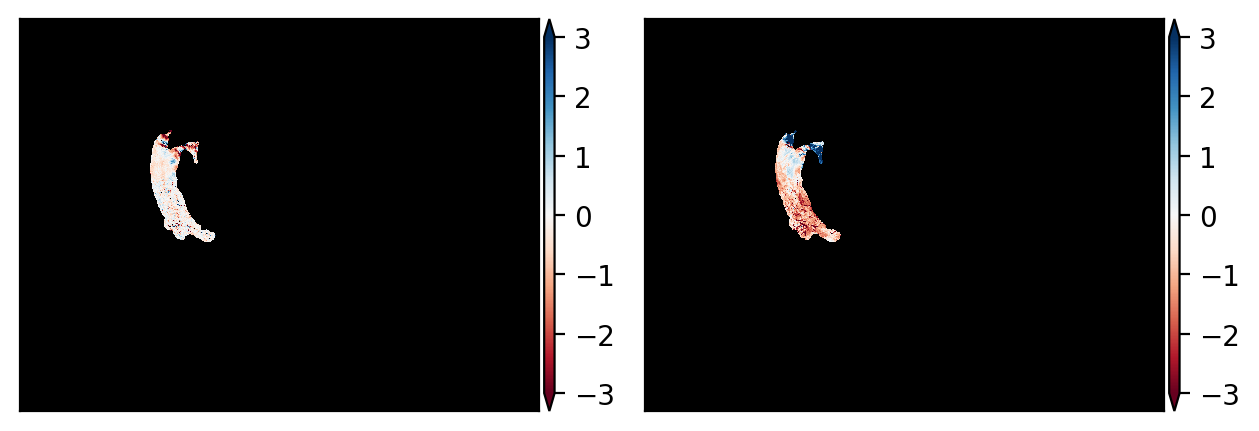

In [20]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
pltlib.iv(smb_winter_bcn,ax=ax[0],cmap='RdBu',clim=(-3,3))
pltlib.iv(smb_summer_bcn,ax=ax[1],cmap='RdBu',clim=(-3,3))

<Axes: >

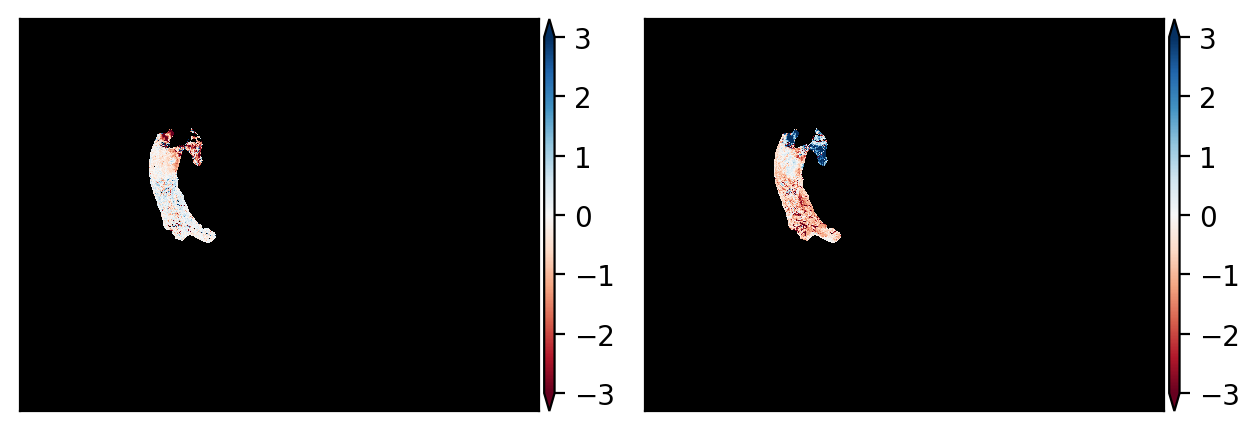

In [21]:
f,ax = plt.subplots(1,2,sharex=True,sharey=True)
pltlib.iv(eul_winter_bcn,ax=ax[0],cmap='RdBu',clim=(-3,3))
pltlib.iv(eul_summer_bcn,ax=ax[1],cmap='RdBu',clim=(-3,3))

<Axes: >

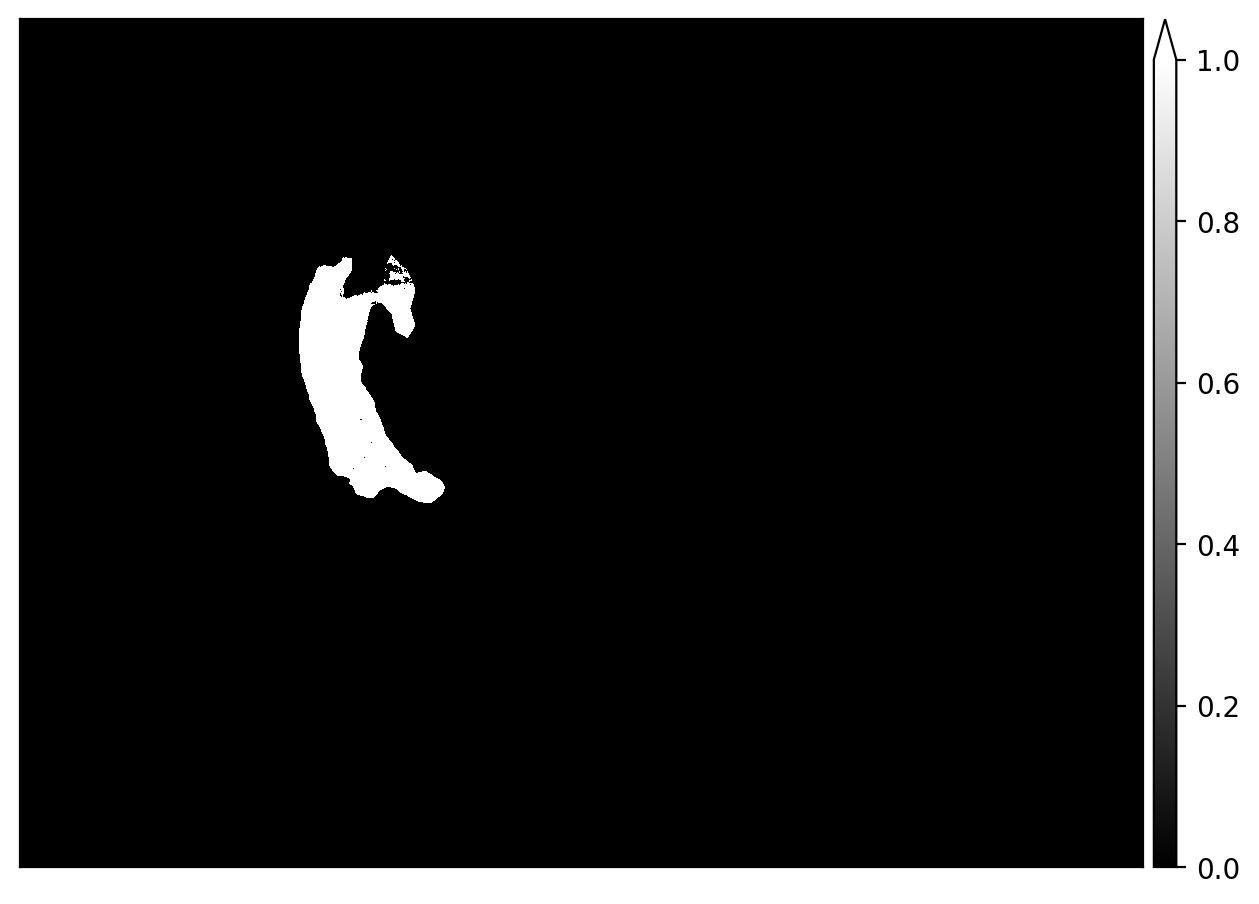

In [22]:
f,ax = plt.subplots()
pltlib.iv(np.ma.array(z1_bcn,mask=z1_bcn.mask),ax=ax,cmap='gray',clim=(0,1))

In [23]:
#this is a hack, I am just passing the smb_dh here, all else (background, clean ice hotspot, velocity) is fake
summer_df = glac_dyn.hist_plot_gmbtools(hotspot_dh=z1,background_dh=z1,clean_ice_dh=z1,
                                        smb_dh=smb_summer_bcn,debris_thick=deb_bcn,vm=z1,z1=z1,
                                        ds=ds_list[0],bin_width=50)

/swbuild/sbhusha1/miniconda3/envs/bhushanGDAL3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [24]:
summer_df.keys()

Index(['med_bg_dhdt', 'nmad_bg_dhdt', 'q1_bg_dhdt', 'q3_bg_dhdt', 'area_bg',
       'med_hotspot_dhdt', 'nmad_hotspot_dhdt', 'q1_hotspot_dhdt',
       'q3_hotspot_dhdt', 'area_hotspot', 'med_clean_dhdt', 'nmad_clean_dhdt',
       'q1_clean_dhdt', 'q3_clean_dhdt', 'area_clean', 'med_total_dhdt',
       'nmad_total_dhdt', 'q1_total_dhdt', 'q3_total_dhdt', 'area_total',
       'med_deb_thick', 'nmad_deb_thick', 'q1_deb_thick', 'q3_deb_thick',
       'med_vm', 'nmad_vm', 'q1_vm', 'q3_vm', 'z_area', 'z_bin_centers'],
      dtype='object')

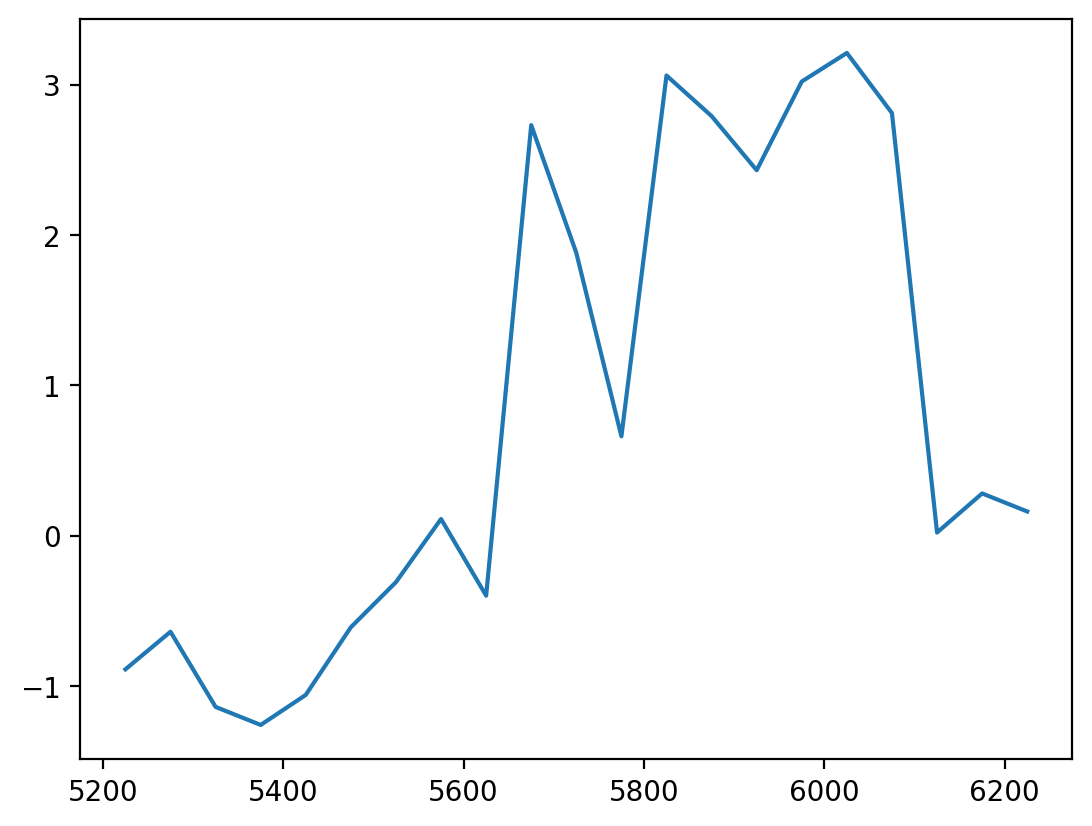

In [25]:
f,ax = plt.subplots()
ax.plot(summer_df.z_bin_centers,summer_df.med_total_dhdt)

In [27]:
#this is a hack, I am just passing the smb_dh here, all else (background, clean ice hotspot, velocity) is fake
winter_df = glac_dyn.hist_plot_gmbtools(hotspot_dh=z1,background_dh=z1,clean_ice_dh=z1,
                                        smb_dh=smb_winter_bcn,debris_thick=deb_bcn,vm=z1,z1=z1,
                                        ds=ds_list[0],bin_width=50)

/swbuild/sbhusha1/miniconda3/envs/bhushanGDAL3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


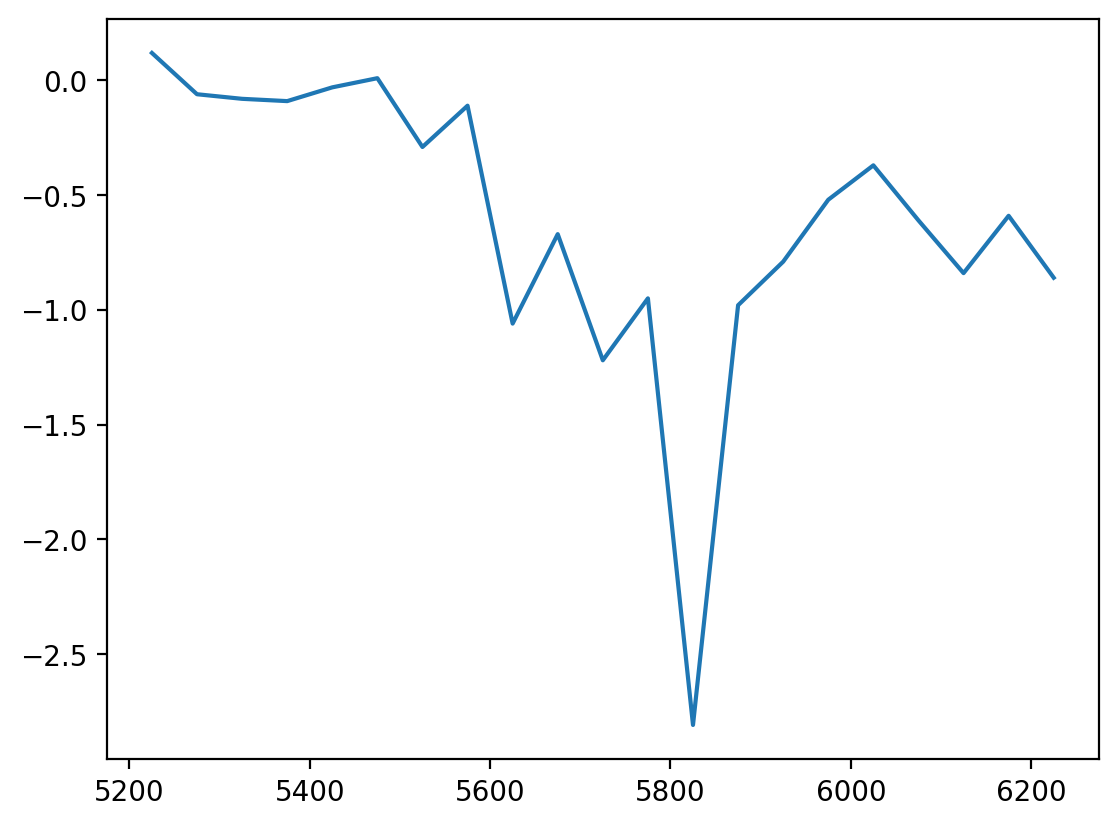

In [28]:
f,ax = plt.subplots()
ax.plot(winter_df.z_bin_centers,winter_df.med_total_dhdt)

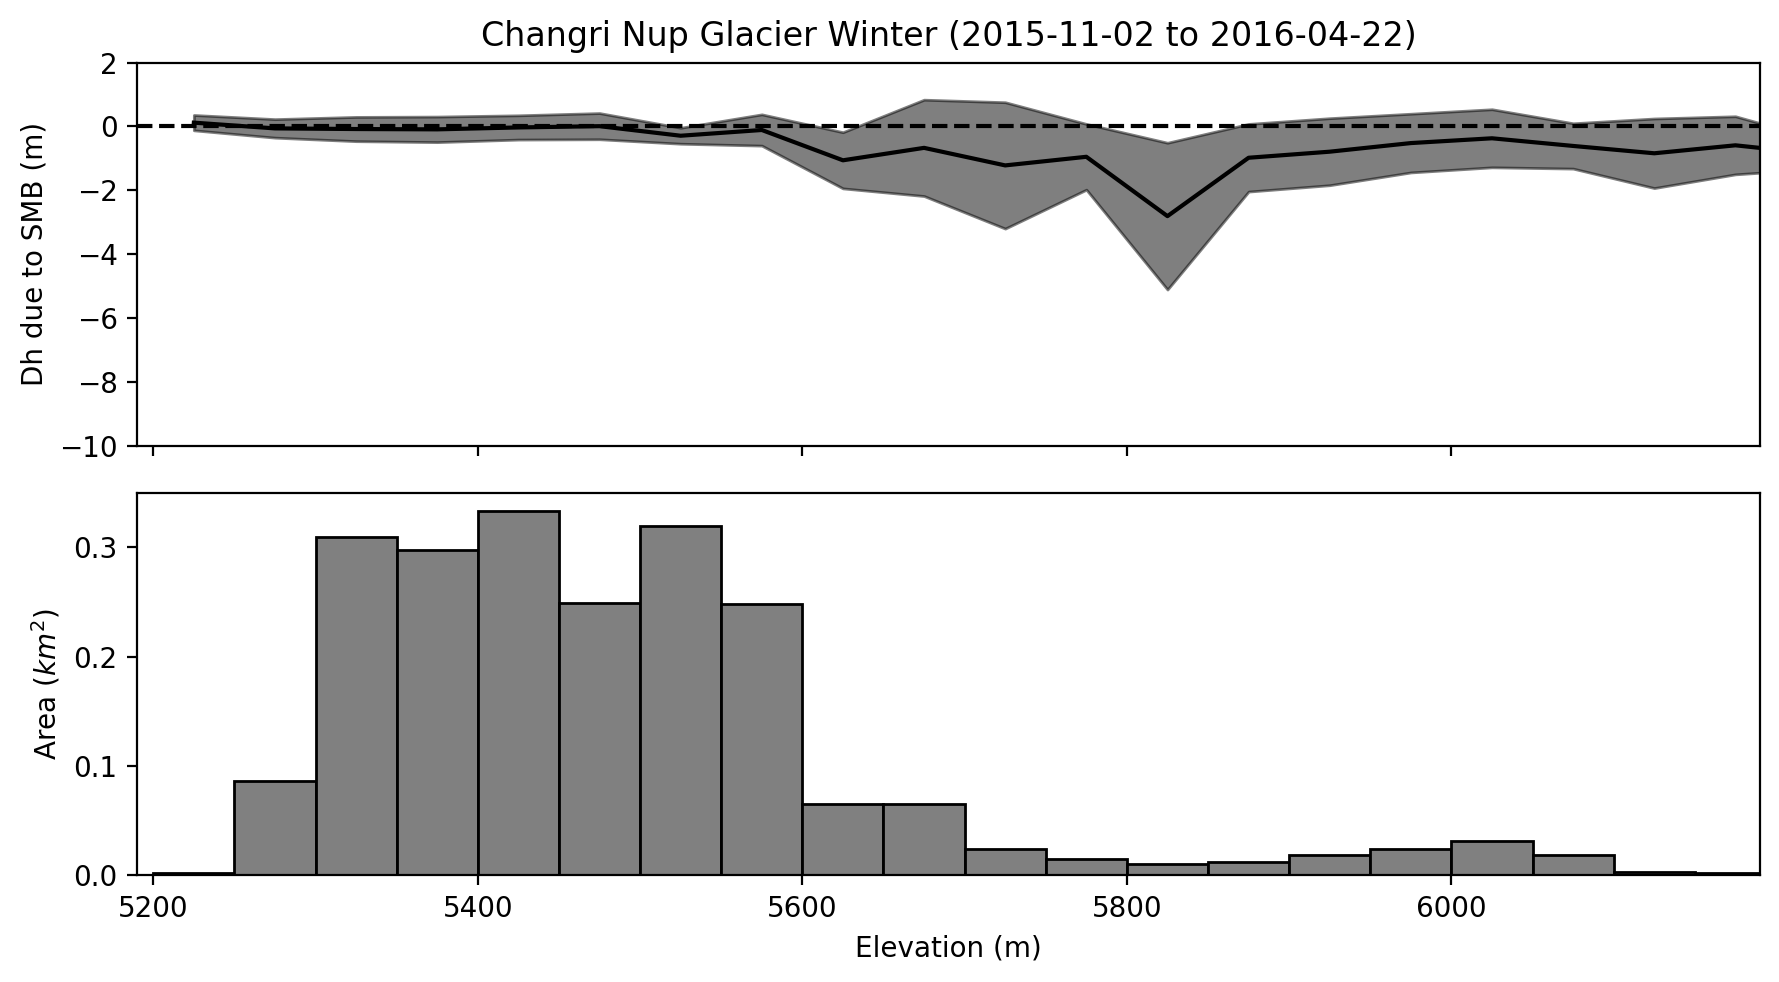

In [29]:
f,ax = plt.subplots(2,1,sharex=True,figsize=(9,5))
#ax2=ax[0].twinx()
#ax2.bar(melt_df.z_bin_centers,melt_df.area_total,color='brown',width=100)
ax[0].plot(winter_df.z_bin_centers,winter_df.med_total_dhdt,color='black')
ax[0].fill_between(winter_df.z_bin_centers,winter_df.med_total_dhdt-winter_df.nmad_total_dhdt,
                winter_df.med_total_dhdt+winter_df.nmad_total_dhdt,color='black',alpha=0.5)
ax[0].set_title('Changri Nup Glacier Winter (2015-11-02 to 2016-04-22)')
#ax.set_xlabel('Elevation (m)')

ax[0].set_ylabel('Dh due to SMB (m)')
ax[0].set_ylim(-10,2)
ax[0].axhline(0,linestyle='--',c='k')

c = 'gray'
"""
debris_box_p = ax[1].bxp(debris_boxes_list_nowhisker,showfliers=False,positions=z_bin_centers,widths=50,
                        patch_artist=True)
plt.setp(debris_box_p['boxes'], color='k')
plt.setp(debris_box_p['medians'], color='k')
plt.setp(debris_box_p["boxes"], facecolor=c)
#for idx in range(len(debris_box_p['boxes'])):
 #   boxes.set(facecolor='gray')
ax[1].set_xticks(np.arange(3900,4700,100))
ax[1].set_ylim(0,.8)
ax[1].set_xticklabels(np.arange(3900,4700,100))

ax[1].set_ylabel('Debris thickness a(m)')
"""
ax[1].bar(winter_df.z_bin_centers,winter_df.area_total,width=50,color='gray',edgecolor='black')
ax[1].set_ylabel('Area ($km^2$)')
ax[1].set_xlabel('Elevation (m)')
ax[1].set_xlim(5190,6190)
plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/agu22/changri_nup_winter.png',dpi=300,bbox_inches='tight',pad_inches=0.1)
#color the box plot by area using blues ...
#edge colors to bar plots in melt seperation figures
# 1 to 1 line for clean ice glaciers smb gradient, not pissible for debris-covered glaciers
# then we can start talking about the accumulation process
#ax2.set_ylabel('Area ($m^2$)')

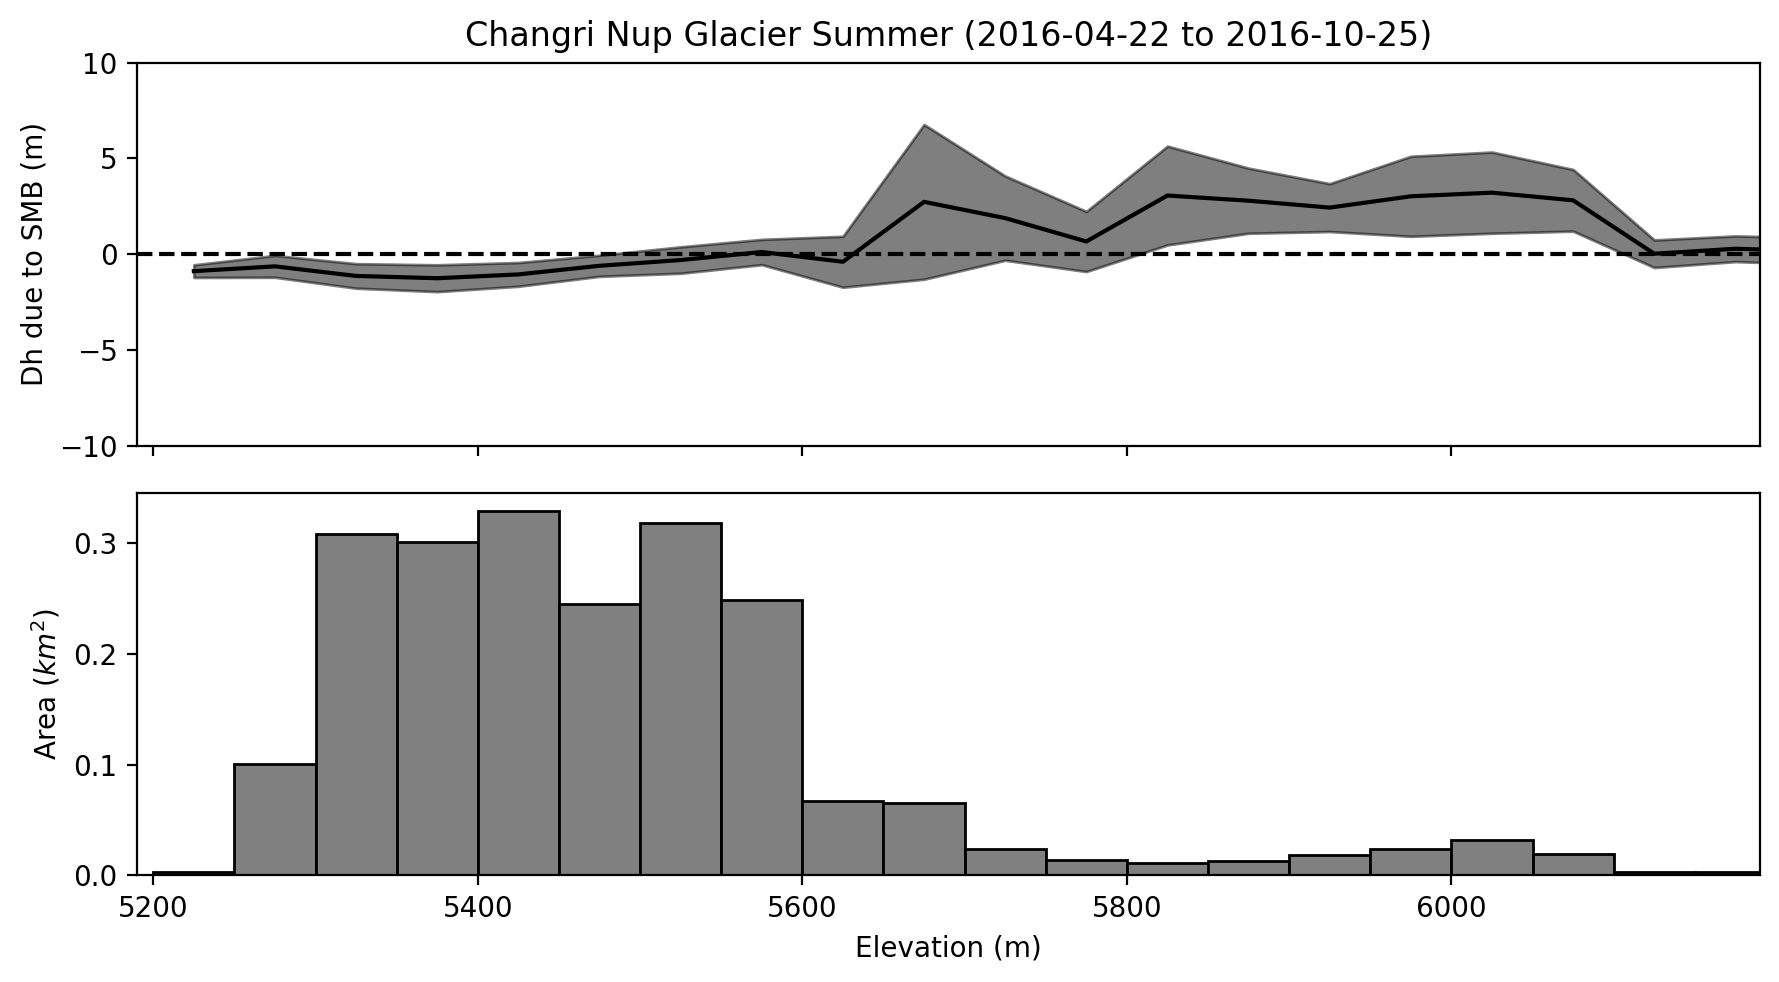

In [31]:
f,ax = plt.subplots(2,1,sharex=True,figsize=(9,5))
#ax2=ax[0].twinx()
#ax2.bar(melt_df.z_bin_centers,melt_df.area_total,color='brown',width=100)
ax[0].plot(summer_df.z_bin_centers,summer_df.med_total_dhdt,color='black')
ax[0].fill_between(summer_df.z_bin_centers,summer_df.med_total_dhdt-summer_df.nmad_total_dhdt,
                summer_df.med_total_dhdt+summer_df.nmad_total_dhdt,color='black',alpha=0.5)
ax[0].set_title('Changri Nup Glacier Summer (2016-04-22 to 2016-10-25)')
#ax.set_xlabel('Elevation (m)')

ax[0].set_ylabel('Dh due to SMB (m)')
ax[0].set_ylim(-10,10)
ax[0].axhline(0,linestyle='--',c='k')

c = 'gray'
"""
debris_box_p = ax[1].bxp(debris_boxes_list_nowhisker,showfliers=False,positions=z_bin_centers,widths=50,
                        patch_artist=True)
plt.setp(debris_box_p['boxes'], color='k')
plt.setp(debris_box_p['medians'], color='k')
plt.setp(debris_box_p["boxes"], facecolor=c)
#for idx in range(len(debris_box_p['boxes'])):
 #   boxes.set(facecolor='gray')
ax[1].set_xticks(np.arange(3900,4700,100))
ax[1].set_ylim(0,.8)
ax[1].set_xticklabels(np.arange(3900,4700,100))

ax[1].set_ylabel('Debris thickness a(m)')
"""
ax[1].bar(summer_df.z_bin_centers,summer_df.area_total,width=50,color='gray',edgecolor='black')
ax[1].set_ylabel('Area ($km^2$)')
ax[1].set_xlabel('Elevation (m)')
ax[1].set_xlim(5190,6190)
plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/agu22/changri_nup_summer.png',dpi=300,bbox_inches='tight',pad_inches=0.1)

In [32]:
area_wt_mb_summer = (summer_df['area_total']*summer_df['med_total_dhdt']).sum()/(summer_df['area_total'].sum())

In [33]:
area_wt_mb_winter = (winter_df['area_total']*winter_df['med_total_dhdt']).sum()/(winter_df['area_total'].sum())

In [34]:
area_wt_mb_summer

-0.380729880949722

In [35]:
area_wt_mb_winter

-0.20520123144140737

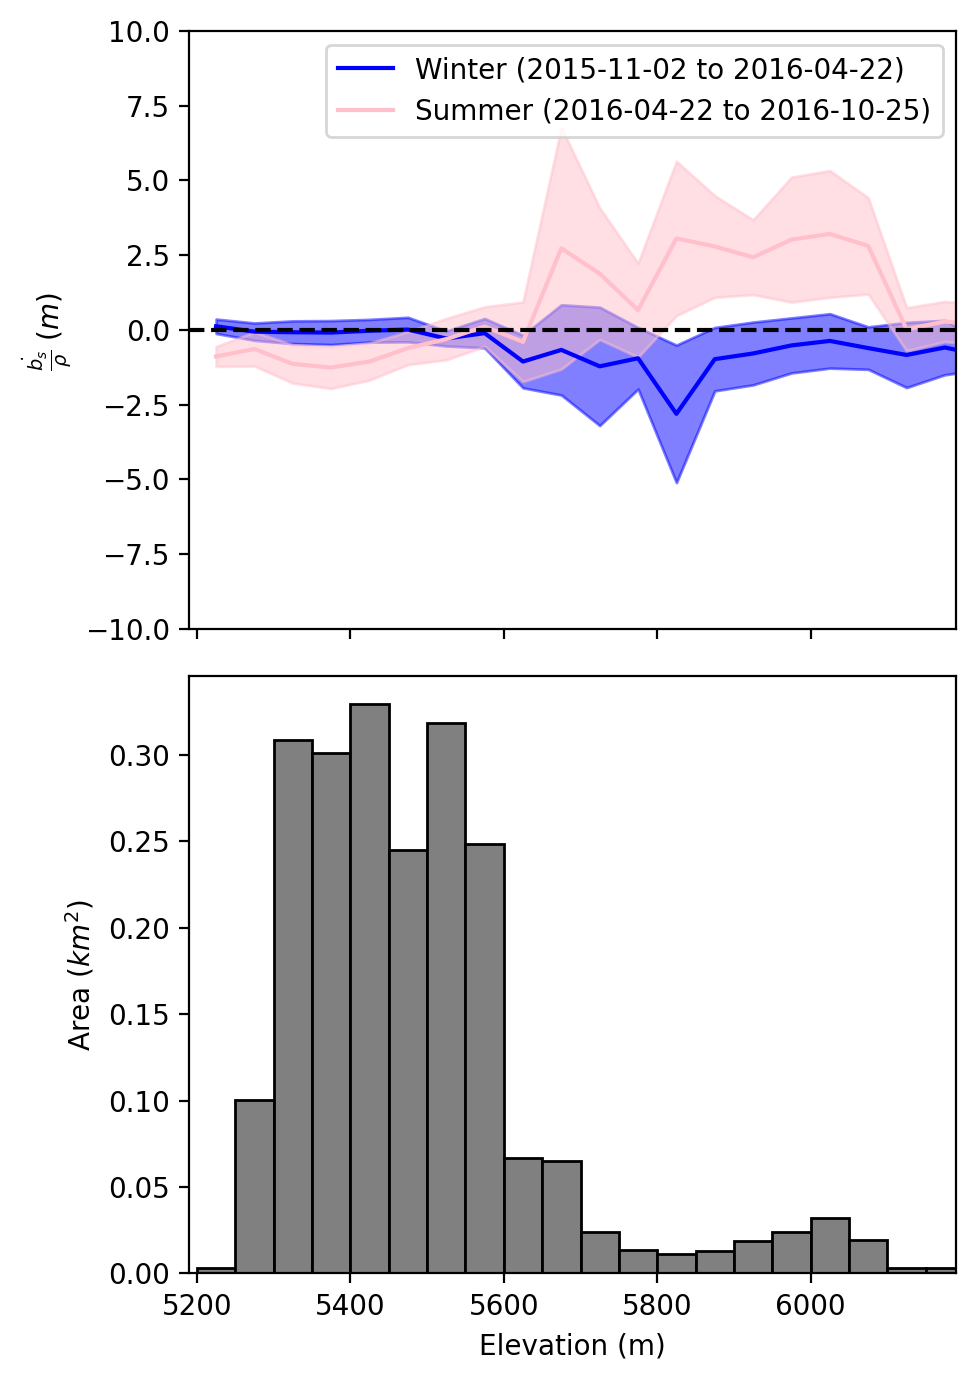

In [36]:
f,ax = plt.subplots(2,1,sharex=True,figsize=(5,7))
gridspec_kw={"height_ratios":[4,3]}
#ax2=ax[0].twinx()
#ax2.bar(melt_df.z_bin_centers,melt_df.area_total,color='brown',width=100)
ax[0].plot(winter_df.z_bin_centers,winter_df.med_total_dhdt,color='blue',label='Winter (2015-11-02 to 2016-04-22)')
ax[0].fill_between(winter_df.z_bin_centers,winter_df.med_total_dhdt-winter_df.nmad_total_dhdt,
                winter_df.med_total_dhdt+winter_df.nmad_total_dhdt,color='blue',alpha=0.5)

ax[0].plot(summer_df.z_bin_centers,summer_df.med_total_dhdt,color='pink',label='Summer (2016-04-22 to 2016-10-25)')
ax[0].fill_between(summer_df.z_bin_centers,summer_df.med_total_dhdt-summer_df.nmad_total_dhdt,
                summer_df.med_total_dhdt+summer_df.nmad_total_dhdt,color='pink',alpha=0.5)


#ax[0].set_title('Changri Nup Glacier Summer (2016-04-22 to 2016-10-25)')
#ax.set_xlabel('Elevation (m)')

ax[0].set_ylabel(r'$\frac{\dot{{b}_{s}}}{\rho}\;(m)$ ')
ax[0].set_ylim(-10,10)
ax[0].axhline(0,linestyle='--',c='k')
ax[0].legend()
c = 'gray'
"""
debris_box_p = ax[1].bxp(debris_boxes_list_nowhisker,showfliers=False,positions=z_bin_centers,widths=50,
                        patch_artist=True)
plt.setp(debris_box_p['boxes'], color='k')
plt.setp(debris_box_p['medians'], color='k')
plt.setp(debris_box_p["boxes"], facecolor=c)
#for idx in range(len(debris_box_p['boxes'])):
 #   boxes.set(facecolor='gray')
ax[1].set_xticks(np.arange(3900,4700,100))
ax[1].set_ylim(0,.8)
ax[1].set_xticklabels(np.arange(3900,4700,100))

ax[1].set_ylabel('Debris thickness a(m)')
"""
ax[1].bar(summer_df.z_bin_centers,summer_df.area_total,width=50,color='gray',edgecolor='black')
ax[1].set_ylabel('Area ($km^2$)')
ax[1].set_xlabel('Elevation (m)')
ax[1].set_xlim(5190,6190)
plt.tight_layout()
plt.savefig('/nobackup/sbhusha1/chapter2/figures/changri_nup_combined.png',dpi=300,bbox_inches='tight',pad_inches=0.1)